In [37]:
import pandas as pd 
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import tensorflow as tf
from tensorflow.keras import layers

In [38]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [39]:
data_path = './dataset_1/train'
wavs_path = data_path + '/audio/'
transcript_path = data_path + '/transcription.txt'

In [40]:
with open(transcript_path, 'r', encoding='utf-8') as file:
    data = file.read()

In [41]:
file_names = []
transcriptions = []

with open(transcript_path, 'r', encoding='utf-8') as file:
    data = file.readlines()

for line in data:
    line = line.strip()  
    if line: 
        parts = line.split(maxsplit=1) 
        if len(parts) == 2:
            file_names.append(parts[0])
            transcriptions.append(parts[1])

df = pd.DataFrame({
    'file_name': file_names,
    'transcription': transcriptions
})

print(df)
df.to_csv(data_path + 'transcriptions.csv', index=False, encoding='utf-8-sig')

      file_name                           transcription
0      0001_030                         यह है मोटा राजा
1      0001_043                         यह है मोटा राजा
2      0002_002            मोटे राजा का है दुबला कुत्ता
3      0002_019            मोटे राजा का है दुबला कुत्ता
4      0002_039            मोटे राजा का है दुबला कुत्ता
...         ...                                     ...
99920  6049_047  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99921  6049_050  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99922  6049_078  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99923  6049_080  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99924  6049_097  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा

[99925 rows x 2 columns]


In [42]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,file_name,transcription
0,2125_046,जरा मुझे बाहर निकाल कर देखो कि मेरा कुंवर ठीक ...
1,3126_077,सिद्धेश्वरीने पूछा
2,2971_019,रामचंद्र बिगड़ उठा
3,5960_037,जब वह स्वयं मंत्रिमंडल में सम्मिलित होता है
4,0026_027,माँ हँस दीं


In [43]:
split = int(len(df)*0.9)
df_train=df[:split]
df_val=df[split:]
print(f"Size of the training set : {len(df_train)}")
print(f"Size of the validation set : {len(df_val)}")

Size of the training set : 89932
Size of the validation set : 9993


# Preprocessing

In [44]:
import numpy as np
from tensorflow import keras

characters = sorted(set("अआइईउऊऋएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहाि ी ु ू ृ े ै ो ौ ं ः ् ँ०१२३४५६७८९'?!। "))

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(f"The vocabulary size is : {char_to_num.get_vocabulary()}")
print(f"size = : {char_to_num.vocabulary_size()}")

The vocabulary size is : ['', ' ', '!', "'", '?', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', '।', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']
size = : 74


In [45]:
frame_length=256
frame_step=160
fft_length=384

In [46]:
# Random sampling
train_sample_size = 50000
test_sample_size = 5000

df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset
df_train = df[:train_sample_size]
df_val = df[train_sample_size:train_sample_size + test_sample_size]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")


Size of the training set: 50000
Size of the validation set: 5000


In [47]:
def encode_single_sample(wav_file, label):
    file=tf.io.read_file(wavs_path+wav_file+".wav")
    audio,_=tf.audio.decode_wav(file)
    audio=tf.squeeze(audio, axis=-1)
    audio=tf.cast(audio, tf.float32)
    spectogram=tf.signal.stft(audio,frame_length=frame_length,frame_step=frame_step,fft_length=fft_length)
    spectogram=tf.abs(spectogram)
    spectogram=tf.math.pow(spectogram, 0.5)
    means=tf.math.reduce_mean(spectogram,1,keepdims=True)
    stddevs=tf.math.reduce_std(spectogram,1,keepdims=True)
    spectogram=(spectogram-means)/(stddevs + 1e-10)
    label=tf.strings.lower(label)
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=char_to_num(label)
    return spectogram, label

In [48]:
batch_size=16

train_dataset=tf.data.Dataset.from_tensor_slices((list(df_train['file_name']), list(df_train['transcription'])))
train_dataset=(train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))


val_dataset=tf.data.Dataset.from_tensor_slices((list(df_val['file_name']), list(df_val['transcription'])))
val_dataset=(val_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI L

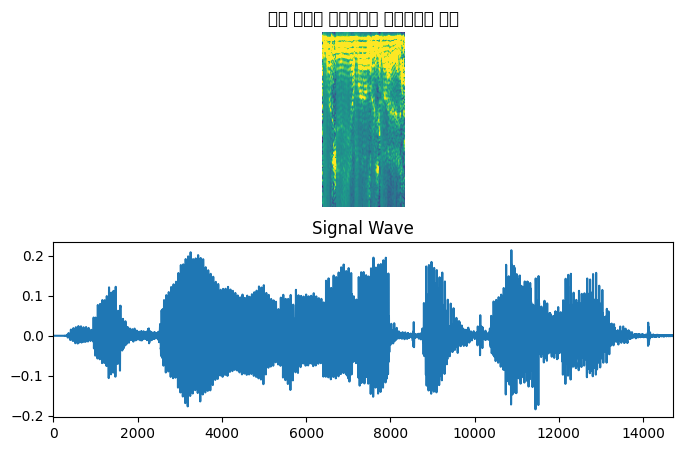

In [49]:
fig=plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    spectogram=batch[0][0].numpy()
    spectogram=np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    label=batch[1][0]

    label=tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax=plt.subplot(2,1,1)
    ax.imshow(spectogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    file=tf.io.read_file(wavs_path+list(df_train["file_name"])[0]+".wav")
    audio,_=tf.audio.decode_wav(file)
    audio=audio.numpy()
    ax=plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


# Model

In [50]:
def CTCLoss(y_true, y_pred):
    batch_len=tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length=tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length=input_length*tf.ones(shape=(batch_len,1),dtype="int64")
    label_length=label_length*tf.ones(shape=(batch_len,1),dtype="int64")

    loss=keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [51]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
    
    x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding='same', use_bias=False, name="conv_1")(x)
    x = layers.BatchNormalization(name='conv_1_bn')(x)
    x = layers.ReLU(name='conv_1_relu')(x)

    x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding='same', use_bias=False, name="conv_2")(x)
    x = layers.BatchNormalization(name='conv_2_bn')(x)
    x = layers.ReLU(name='conv_2_relu')(x)

    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True, reset_after=True, name=f"gru_{i}")
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode='concat')(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    x = layers.Dense(units=rnn_units * 2, name='dense_1')(x)
    x = layers.ReLU(name='dense_1_relu')(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=output_dim + 1, activation='softmax', name='dense_output')(x)
    model = keras.Model(input_spectogram, output, name='DeepSpeech2')
    opt = keras.optimizers.Adam(learning_rate=1e-4)  # Corrected line
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


In [52]:
model=build_model(input_dim=fft_length//2+1, output_dim=char_to_num.vocabulary_size(), rnn_units=512,)
model.summary(line_length=110)

Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape_2 (Reshape)                            │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_10 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_11 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_12 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_13 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,672,555 (101.75 MB)

 Trainable params: 26,672,427 (101.75 MB)

 Non-trainable params: 128 (512.00 B)

# Training

In [53]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [54]:
class CallbackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
    def on_epoch_end(self, epoch: int, logs=None):
        predictions=[]
        targets=[]
        for batch in self.dataset:
            X,y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("*"*100)
        print(f"Word Error Rate : {wer_score:.4f}")
        print("*"*100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target : {targets[i]}")
            print(f"Prediction : {predictions[i]}")
            print("*"*100)

In [55]:
epochs = 5
validation_callback = CallbackEval(val_dataset)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/5
 436/3125 ━━━━━━━━━━━━━━━━━━━━ 9:08:28 12s/step - loss: 143.9327

2024-11-22 14:02:23.635516: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635659: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635715: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635783: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635811: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635834: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635858: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635882: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635909: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:02:23.635928: W ./tensorflow/core/util/ct

 441/3125 ━━━━━━━━━━━━━━━━━━━━ 9:07:30 12s/step - loss: inf 

2024-11-22 14:03:25.357254: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 502/3125 ━━━━━━━━━━━━━━━━━━━━ 8:51:54 12s/step - loss: inf

2024-11-22 14:15:15.747797: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 517/3125 ━━━━━━━━━━━━━━━━━━━━ 8:49:41 12s/step - loss: inf

2024-11-22 14:18:28.161986: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:18:28.162051: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:18:28.162115: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 14:18:28.162270: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 857/3125 ━━━━━━━━━━━━━━━━━━━━ 7:41:12 12s/step - loss: inf

2024-11-22 15:27:44.285323: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 906/3125 ━━━━━━━━━━━━━━━━━━━━ 7:29:58 12s/step - loss: inf

2024-11-22 15:37:11.164641: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164714: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164769: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164799: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164823: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164845: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164871: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164898: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164924: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:37:11.164947: W ./tensorflow/core/util/ct

 951/3125 ━━━━━━━━━━━━━━━━━━━━ 7:20:21 12s/step - loss: inf

2024-11-22 15:46:05.753300: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:46:05.753497: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:46:05.753519: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:46:05.753546: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:46:05.753595: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:46:05.753624: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 15:46:05.753651: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1101/3125 ━━━━━━━━━━━━━━━━━━━━ 6:50:30 12s/step - loss: inf

2024-11-22 16:16:45.610097: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:16:45.610154: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1173/3125 ━━━━━━━━━━━━━━━━━━━━ 6:36:03 12s/step - loss: inf

2024-11-22 16:31:27.795551: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:31:27.795783: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:31:27.795962: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1212/3125 ━━━━━━━━━━━━━━━━━━━━ 6:28:31 12s/step - loss: inf

2024-11-22 16:39:37.168190: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1239/3125 ━━━━━━━━━━━━━━━━━━━━ 6:22:23 12s/step - loss: inf

2024-11-22 16:44:40.583088: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:44:40.583141: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:44:40.583158: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:44:40.583177: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:44:40.583191: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:44:40.583212: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:44:40.583233: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 16:44:40.583680: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1480/3125 ━━━━━━━━━━━━━━━━━━━━ 5:32:56 12s/step - loss: inf

2024-11-22 17:33:00.234125: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234184: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234217: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234239: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234258: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234281: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234296: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234320: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234390: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 17:33:00.234409: W ./tensorflow/core/util/ct

1642/3125 ━━━━━━━━━━━━━━━━━━━━ 5:00:05 12s/step - loss: inf

2024-11-22 18:05:43.871484: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1740/3125 ━━━━━━━━━━━━━━━━━━━━ 4:40:55 12s/step - loss: inf

2024-11-22 18:26:23.340092: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1841/3125 ━━━━━━━━━━━━━━━━━━━━ 4:20:36 12s/step - loss: inf

2024-11-22 18:47:07.038591: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 18:47:07.038683: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 18:47:07.038878: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1906/3125 ━━━━━━━━━━━━━━━━━━━━ 4:07:10 12s/step - loss: inf

2024-11-22 18:59:56.396511: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 18:59:56.396734: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1934/3125 ━━━━━━━━━━━━━━━━━━━━ 4:01:32 12s/step - loss: inf

2024-11-22 19:05:41.652327: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2027/3125 ━━━━━━━━━━━━━━━━━━━━ 3:42:39 12s/step - loss: inf

2024-11-22 19:24:29.973460: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 19:24:29.973660: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2205/3125 ━━━━━━━━━━━━━━━━━━━━ 3:06:29 12s/step - loss: inf

2024-11-22 20:00:25.444521: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 20:00:25.444800: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 20:00:25.444833: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 20:00:25.444925: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 20:00:25.444950: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 20:00:25.445418: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2626/3125 ━━━━━━━━━━━━━━━━━━━━ 1:41:40 12s/step - loss: inf

2024-11-22 21:28:34.047695: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 21:28:34.047774: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 21:28:34.047795: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 21:28:34.047821: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 21:28:34.047875: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 21:28:34.047903: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 21:28:34.047929: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 21:28:34.047956: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2789/3125 ━━━━━━━━━━━━━━━━━━━━ 1:08:32 12s/step - loss: inf

2024-11-22 22:02:23.080257: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:02:23.080333: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:02:23.080829: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2824/3125 ━━━━━━━━━━━━━━━━━━━━ 1:01:23 12s/step - loss: inf

2024-11-22 22:09:23.392580: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:09:23.392641: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:09:23.392690: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2856/3125 ━━━━━━━━━━━━━━━━━━━━ 54:48 12s/step - loss: inf

2024-11-22 22:15:21.979142: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2988/3125 ━━━━━━━━━━━━━━━━━━━━ 27:54 12s/step - loss: inf

2024-11-22 22:42:15.295820: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:42:15.295946: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:42:15.296009: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:42:15.296058: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:42:15.296777: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3009/3125 ━━━━━━━━━━━━━━━━━━━━ 23:37 12s/step - loss: inf

2024-11-22 22:46:19.761807: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.761924: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.761971: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.762183: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.762212: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.762266: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.762329: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.762348: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.762387: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 22:46:19.762407: W ./tensorflow/core/util/ct

3124/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: inf

2024-11-22 23:10:00.513006: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513054: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513109: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513174: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513206: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513235: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513256: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513281: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513303: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:10:00.513334: W ./tensorflow/core/util/ct

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: inf 

2024-11-22 23:11:33.405886: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839197: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839253: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839297: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839312: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839336: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839359: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839378: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839402: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-22 23:14:35.839424: W ./tensorflow/core/util/ct

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-11-22 23:25:31.387894: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 436/3125 ━━━━━━━━━━━━━━━━━━━━ 9:22:02 13s/step - loss: 96.1046

2024-11-23 00:56:38.927555: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927618: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927695: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927791: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927829: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927860: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927873: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927900: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927927: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 00:56:38.927957: W ./tensorflow/core/util/ct

 441/3125 ━━━━━━━━━━━━━━━━━━━━ 9:21:06 13s/step - loss: inf

2024-11-23 00:57:42.740896: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 502/3125 ━━━━━━━━━━━━━━━━━━━━ 9:05:19 12s/step - loss: inf

2024-11-23 01:09:53.037347: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 517/3125 ━━━━━━━━━━━━━━━━━━━━ 9:03:09 12s/step - loss: inf

2024-11-23 01:13:11.351317: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 01:13:11.351529: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 01:13:11.351587: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 01:13:11.351772: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 857/3125 ━━━━━━━━━━━━━━━━━━━━ 7:52:51 13s/step - loss: inf

2024-11-23 02:24:11.587571: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 906/3125 ━━━━━━━━━━━━━━━━━━━━ 7:40:57 12s/step - loss: inf

2024-11-23 02:33:43.657871: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658014: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658061: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658082: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658101: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658125: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658146: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658172: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658192: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:33:43.658215: W ./tensorflow/core/util/ct

 951/3125 ━━━━━━━━━━━━━━━━━━━━ 7:30:48 12s/step - loss: inf

2024-11-23 02:42:43.468306: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:42:43.468516: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:42:43.468546: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:42:43.468567: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:42:43.468596: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:42:43.468643: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 02:42:43.468845: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1101/3125 ━━━━━━━━━━━━━━━━━━━━ 6:59:03 12s/step - loss: inf

2024-11-23 03:13:27.864045: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:13:27.864124: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1173/3125 ━━━━━━━━━━━━━━━━━━━━ 6:43:49 12s/step - loss: inf

2024-11-23 03:28:10.878879: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:28:10.878934: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:28:10.878955: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1212/3125 ━━━━━━━━━━━━━━━━━━━━ 6:35:44 12s/step - loss: inf

2024-11-23 03:36:14.418537: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1239/3125 ━━━━━━━━━━━━━━━━━━━━ 6:29:14 12s/step - loss: inf

2024-11-23 03:41:14.249013: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:41:14.249303: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:41:14.249323: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:41:14.249345: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:41:14.249374: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:41:14.249426: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:41:14.249456: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 03:41:14.249485: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1480/3125 ━━━━━━━━━━━━━━━━━━━━ 5:37:04 12s/step - loss: inf

2024-11-23 04:28:46.196879: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.196926: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.196952: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.196976: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.197000: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.197048: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.197143: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.197218: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.197270: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 04:28:46.197286: W ./tensorflow/core/util/ct

1642/3125 ━━━━━━━━━━━━━━━━━━━━ 5:03:30 12s/step - loss: inf

2024-11-23 05:01:33.191387: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1740/3125 ━━━━━━━━━━━━━━━━━━━━ 4:44:01 12s/step - loss: inf

2024-11-23 05:22:20.533312: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1841/3125 ━━━━━━━━━━━━━━━━━━━━ 4:23:33 12s/step - loss: inf

2024-11-23 05:43:24.923054: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 05:43:24.923118: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 05:43:24.923295: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1906/3125 ━━━━━━━━━━━━━━━━━━━━ 4:10:03 12s/step - loss: inf

2024-11-23 05:56:30.063137: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 05:56:30.063205: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1934/3125 ━━━━━━━━━━━━━━━━━━━━ 4:04:24 12s/step - loss: inf

2024-11-23 06:02:23.054117: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2027/3125 ━━━━━━━━━━━━━━━━━━━━ 3:45:22 12s/step - loss: inf

2024-11-23 06:21:35.294443: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 06:21:35.294499: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2205/3125 ━━━━━━━━━━━━━━━━━━━━ 3:08:50 12s/step - loss: inf

2024-11-23 06:58:08.701908: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 06:58:08.701967: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 06:58:08.702023: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 06:58:08.702049: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 06:58:08.702073: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 06:58:08.702546: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2626/3125 ━━━━━━━━━━━━━━━━━━━━ 1:43:05 12s/step - loss: inf

2024-11-23 08:28:02.464179: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 08:28:02.464237: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 08:28:02.464286: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 08:28:02.464309: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 08:28:02.464334: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 08:28:02.464361: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 08:28:02.464382: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 08:28:02.464588: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2789/3125 ━━━━━━━━━━━━━━━━━━━━ 1:09:28 12s/step - loss: inf

2024-11-23 09:02:14.737475: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:02:14.737535: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:02:14.737557: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2824/3125 ━━━━━━━━━━━━━━━━━━━━ 1:02:13 12s/step - loss: inf

2024-11-23 09:09:17.240427: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:09:17.240700: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:09:17.240782: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2856/3125 ━━━━━━━━━━━━━━━━━━━━ 55:33 12s/step - loss: inf

2024-11-23 09:15:19.878603: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2988/3125 ━━━━━━━━━━━━━━━━━━━━ 28:17 12s/step - loss: inf

2024-11-23 09:42:31.961624: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:42:31.961676: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:42:31.961698: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:42:31.961731: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:42:31.961749: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3009/3125 ━━━━━━━━━━━━━━━━━━━━ 23:56 12s/step - loss: inf

2024-11-23 09:46:40.688844: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.688899: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.688936: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.689019: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.689034: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.689057: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.689079: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.689094: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.689116: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 09:46:40.689135: W ./tensorflow/core/util/ct

3124/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: inf

2024-11-23 10:10:38.429039: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429097: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429152: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429198: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429229: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429314: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429343: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429380: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429395: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:10:38.429422: W ./tensorflow/core/util/ct

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: inf 

2024-11-23 10:12:11.593932: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895449: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895502: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895543: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895568: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895585: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895607: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895635: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895689: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 10:15:15.895703: W ./tensorflow/core/util/ct

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-11-23 11:58:07.122263: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.122462: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.122483: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.122549: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.122586: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.122619: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.122652: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.122970: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.123049: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 11:58:07.123093: W ./tensorflow/core/util/ct

 441/3125 ━━━━━━━━━━━━━━━━━━━━ 9:25:49 13s/step - loss: inf

2024-11-23 11:59:11.585187: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 502/3125 ━━━━━━━━━━━━━━━━━━━━ 9:07:52 13s/step - loss: inf

2024-11-23 12:11:04.644438: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 517/3125 ━━━━━━━━━━━━━━━━━━━━ 9:05:11 13s/step - loss: inf

2024-11-23 12:14:17.880390: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 12:14:17.880436: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 12:14:17.880513: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 12:14:17.880534: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 857/3125 ━━━━━━━━━━━━━━━━━━━━ 7:52:33 13s/step - loss: inf

2024-11-23 13:24:46.859978: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 906/3125 ━━━━━━━━━━━━━━━━━━━━ 7:39:56 12s/step - loss: inf

2024-11-23 13:34:01.008943: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009003: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009033: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009065: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009108: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009154: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009183: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009215: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009235: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:34:01.009256: W ./tensorflow/core/util/ct

 951/3125 ━━━━━━━━━━━━━━━━━━━━ 7:29:12 12s/step - loss: inf

2024-11-23 13:42:43.486920: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:42:43.487004: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:42:43.487547: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:42:43.487681: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:42:43.487724: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:42:43.487807: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 13:42:43.487836: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1101/3125 ━━━━━━━━━━━━━━━━━━━━ 6:56:02 12s/step - loss: inf

2024-11-23 14:12:32.037061: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:12:32.037553: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1173/3125 ━━━━━━━━━━━━━━━━━━━━ 6:40:09 12s/step - loss: inf

2024-11-23 14:26:41.513027: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:26:41.513081: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:26:41.513101: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1212/3125 ━━━━━━━━━━━━━━━━━━━━ 6:31:51 12s/step - loss: inf

2024-11-23 14:34:29.466163: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1239/3125 ━━━━━━━━━━━━━━━━━━━━ 6:25:18 12s/step - loss: inf

2024-11-23 14:39:21.510766: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:39:21.510827: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:39:21.510851: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:39:21.510997: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:39:21.511018: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:39:21.511043: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:39:21.511096: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 14:39:21.511127: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1480/3125 ━━━━━━━━━━━━━━━━━━━━ 5:32:32 12s/step - loss: inf

2024-11-23 15:25:24.722215: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722276: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722327: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722364: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722387: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722409: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722433: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722459: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722482: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 15:25:24.722501: W ./tensorflow/core/util/ct

1642/3125 ━━━━━━━━━━━━━━━━━━━━ 4:58:20 12s/step - loss: inf

2024-11-23 15:56:32.905495: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1740/3125 ━━━━━━━━━━━━━━━━━━━━ 4:38:30 12s/step - loss: inf

2024-11-23 16:16:06.673462: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1841/3125 ━━━━━━━━━━━━━━━━━━━━ 4:17:48 12s/step - loss: inf

2024-11-23 16:35:51.565974: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 16:35:51.566038: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 16:35:51.566084: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1906/3125 ━━━━━━━━━━━━━━━━━━━━ 4:04:13 12s/step - loss: inf

2024-11-23 16:48:05.498637: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 16:48:05.499356: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1934/3125 ━━━━━━━━━━━━━━━━━━━━ 3:58:31 12s/step - loss: inf

2024-11-23 16:53:32.963256: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2027/3125 ━━━━━━━━━━━━━━━━━━━━ 3:39:28 12s/step - loss: inf

2024-11-23 17:11:24.594656: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 17:11:24.594867: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2205/3125 ━━━━━━━━━━━━━━━━━━━━ 3:03:18 12s/step - loss: inf

2024-11-23 17:45:34.797850: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 17:45:34.797960: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 17:45:34.798010: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 17:45:34.798029: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 17:45:34.798497: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 17:45:34.798581: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2626/3125 ━━━━━━━━━━━━━━━━━━━━ 1:39:40 12s/step - loss: inf

2024-11-23 19:10:46.292370: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:10:46.292417: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:10:46.292441: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:10:46.292459: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:10:46.292585: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:10:46.292607: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:10:46.292623: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:10:46.292646: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2789/3125 ━━━━━━━━━━━━━━━━━━━━ 1:07:20 12s/step - loss: inf

2024-11-23 19:45:09.791228: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:45:09.791304: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:45:09.791463: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2824/3125 ━━━━━━━━━━━━━━━━━━━━ 1:00:20 12s/step - loss: inf

2024-11-23 19:52:19.593292: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:52:19.593392: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 19:52:19.593435: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2856/3125 ━━━━━━━━━━━━━━━━━━━━ 53:53 12s/step - loss: inf

2024-11-23 19:58:29.370196: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2988/3125 ━━━━━━━━━━━━━━━━━━━━ 27:30 12s/step - loss: inf

2024-11-23 20:26:20.273226: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:26:20.273303: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:26:20.273332: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:26:20.273358: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:26:20.273403: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3009/3125 ━━━━━━━━━━━━━━━━━━━━ 23:17 12s/step - loss: inf

2024-11-23 20:30:30.963874: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.963964: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964016: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964051: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964167: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964323: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964344: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964363: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964830: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:30:30.964850: W ./tensorflow/core/util/ct

3124/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: inf

2024-11-23 20:54:29.783350: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783402: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783450: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783479: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783501: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783528: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783551: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783571: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783593: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:54:29.783662: W ./tensorflow/core/util/ct

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: inf 

2024-11-23 20:56:00.079303: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.711826: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.711883: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.711927: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.711946: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.711969: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.711992: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.712008: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.712030: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 20:58:59.712049: W ./tensorflow/core/util/ct

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-11-23 22:41:12.659978: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660191: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660209: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660228: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660284: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660327: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660359: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660387: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660480: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:41:12.660557: W ./tensorflow/core/util/ct

 441/3125 ━━━━━━━━━━━━━━━━━━━━ 9:24:56 13s/step - loss: inf

2024-11-23 22:42:18.174395: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 502/3125 ━━━━━━━━━━━━━━━━━━━━ 9:10:43 13s/step - loss: inf

2024-11-23 22:54:52.816831: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 517/3125 ━━━━━━━━━━━━━━━━━━━━ 9:08:50 13s/step - loss: inf

2024-11-23 22:58:16.662192: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:58:16.662344: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:58:16.662425: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-23 22:58:16.662531: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 857/3125 ━━━━━━━━━━━━━━━━━━━━ 8:04:40 13s/step - loss: inf

2024-11-24 00:12:37.283582: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 906/3125 ━━━━━━━━━━━━━━━━━━━━ 7:53:57 13s/step - loss: inf

2024-11-24 00:22:59.339728: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339780: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339800: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339862: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339882: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339906: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339935: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339963: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.339996: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:22:59.340024: W ./tensorflow/core/util/ct

 951/3125 ━━━━━━━━━━━━━━━━━━━━ 7:44:12 13s/step - loss: inf

2024-11-24 00:32:32.747504: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:32:32.747567: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:32:32.747593: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:32:32.747633: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:32:32.747662: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:32:32.747718: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 00:32:32.747855: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1101/3125 ━━━━━━━━━━━━━━━━━━━━ 7:14:47 13s/step - loss: inf

2024-11-24 01:05:59.403162: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:05:59.403318: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1173/3125 ━━━━━━━━━━━━━━━━━━━━ 7:00:48 13s/step - loss: inf

2024-11-24 01:22:20.697855: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:22:20.698384: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:22:20.698411: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1212/3125 ━━━━━━━━━━━━━━━━━━━━ 6:52:35 13s/step - loss: inf

2024-11-24 01:30:52.331564: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1239/3125 ━━━━━━━━━━━━━━━━━━━━ 6:45:56 13s/step - loss: inf

2024-11-24 01:36:09.520796: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:36:09.521028: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:36:09.521085: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:36:09.521126: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:36:09.521294: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:36:09.521461: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:36:09.521487: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 01:36:09.521922: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1480/3125 ━━━━━━━━━━━━━━━━━━━━ 5:51:59 13s/step - loss: inf

2024-11-24 02:26:09.168166: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168230: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168277: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168297: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168316: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168342: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168364: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168385: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168407: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 02:26:09.168430: W ./tensorflow/core/util/ct

1642/3125 ━━━━━━━━━━━━━━━━━━━━ 5:16:48 13s/step - loss: inf

2024-11-24 03:00:14.135477: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1740/3125 ━━━━━━━━━━━━━━━━━━━━ 4:56:02 13s/step - loss: inf

2024-11-24 03:21:23.688177: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1841/3125 ━━━━━━━━━━━━━━━━━━━━ 4:34:18 13s/step - loss: inf

2024-11-24 03:42:46.633564: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 03:42:46.633761: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 03:42:46.633788: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1906/3125 ━━━━━━━━━━━━━━━━━━━━ 4:19:59 13s/step - loss: inf

2024-11-24 03:55:58.677316: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 03:55:58.677533: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1934/3125 ━━━━━━━━━━━━━━━━━━━━ 4:13:59 13s/step - loss: inf

2024-11-24 04:01:54.150224: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2027/3125 ━━━━━━━━━━━━━━━━━━━━ 3:53:42 13s/step - loss: inf

2024-11-24 04:20:56.048410: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 04:20:56.048959: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2205/3125 ━━━━━━━━━━━━━━━━━━━━ 3:14:28 13s/step - loss: inf

2024-11-24 04:55:34.891404: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 04:55:34.891477: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 04:55:34.891513: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 04:55:34.891575: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 04:55:34.891598: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 04:55:34.891623: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2626/3125 ━━━━━━━━━━━━━━━━━━━━ 1:45:26 13s/step - loss: inf

2024-11-24 06:24:19.402717: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:24:19.402876: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:24:19.402908: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:24:19.402931: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:24:19.402986: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:24:19.403018: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:24:19.403043: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:24:19.403207: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2789/3125 ━━━━━━━━━━━━━━━━━━━━ 1:10:45 13s/step - loss: inf

2024-11-24 06:56:45.162935: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:56:45.163108: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 06:56:45.163613: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2824/3125 ━━━━━━━━━━━━━━━━━━━━ 1:03:18 13s/step - loss: inf

2024-11-24 07:03:26.092546: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:03:26.092631: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:03:26.092684: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2856/3125 ━━━━━━━━━━━━━━━━━━━━ 56:29 13s/step - loss: inf

2024-11-24 07:09:10.636846: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2988/3125 ━━━━━━━━━━━━━━━━━━━━ 28:40 13s/step - loss: inf

2024-11-24 07:34:56.558502: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:34:56.558577: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:34:56.558632: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:34:56.558654: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:34:56.558830: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3009/3125 ━━━━━━━━━━━━━━━━━━━━ 24:15 13s/step - loss: inf

2024-11-24 07:38:49.914930: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915027: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915068: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915105: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915134: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915185: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915212: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915233: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915265: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 07:38:49.915280: W ./tensorflow/core/util/ct

3124/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 13s/step - loss: inf

2024-11-24 08:01:19.549531: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549606: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549659: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549684: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549703: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549726: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549751: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549776: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549796: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:01:19.549816: W ./tensorflow/core/util/ct

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: inf 

2024-11-24 08:02:44.470184: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.300938: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301057: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301095: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301118: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301141: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301261: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301433: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301456: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 08:05:33.301481: W ./tensorflow/core/util/ct

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-11-24 09:41:37.841272: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841332: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841367: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841406: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841443: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841460: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841485: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841533: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841561: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:41:37.841588: W ./tensorflow/core/util/ct

 441/3125 ━━━━━━━━━━━━━━━━━━━━ 8:50:28 12s/step - loss: inf

2024-11-24 09:42:37.759895: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 502/3125 ━━━━━━━━━━━━━━━━━━━━ 8:35:19 12s/step - loss: inf

2024-11-24 09:54:05.565010: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 517/3125 ━━━━━━━━━━━━━━━━━━━━ 8:33:11 12s/step - loss: inf

2024-11-24 09:57:11.922267: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:57:11.922363: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:57:11.922387: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 09:57:11.922461: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 857/3125 ━━━━━━━━━━━━━━━━━━━━ 7:27:59 12s/step - loss: inf

2024-11-24 11:04:44.746549: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 906/3125 ━━━━━━━━━━━━━━━━━━━━ 7:17:17 12s/step - loss: inf

2024-11-24 11:14:00.875729: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875794: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875841: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875863: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875888: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875908: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875936: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875959: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.875985: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:14:00.876010: W ./tensorflow/core/util/ct

 951/3125 ━━━━━━━━━━━━━━━━━━━━ 7:08:07 12s/step - loss: inf

2024-11-24 11:22:45.066400: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:22:45.066475: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:22:45.066542: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:22:45.066567: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:22:45.066585: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:22:45.066610: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:22:45.066753: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1101/3125 ━━━━━━━━━━━━━━━━━━━━ 6:39:12 12s/step - loss: inf

2024-11-24 11:52:37.289399: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 11:52:37.289466: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1173/3125 ━━━━━━━━━━━━━━━━━━━━ 6:24:58 12s/step - loss: inf

2024-11-24 12:06:48.327620: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:06:48.328131: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:06:48.328596: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1212/3125 ━━━━━━━━━━━━━━━━━━━━ 6:17:29 12s/step - loss: inf

2024-11-24 12:14:37.578599: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1239/3125 ━━━━━━━━━━━━━━━━━━━━ 6:11:26 12s/step - loss: inf

2024-11-24 12:19:29.178132: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:19:29.178211: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:19:29.178274: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:19:29.178303: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:19:29.178355: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:19:29.178372: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:19:29.178406: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 12:19:29.178442: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1480/3125 ━━━━━━━━━━━━━━━━━━━━ 5:22:30 12s/step - loss: inf

2024-11-24 13:05:37.623613: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623672: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623697: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623742: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623758: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623779: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623800: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623820: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623874: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 13:05:37.623893: W ./tensorflow/core/util/ct

1642/3125 ━━━━━━━━━━━━━━━━━━━━ 4:50:11 12s/step - loss: inf

2024-11-24 13:36:46.116051: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1740/3125 ━━━━━━━━━━━━━━━━━━━━ 4:31:23 12s/step - loss: inf

2024-11-24 13:56:25.794392: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1841/3125 ━━━━━━━━━━━━━━━━━━━━ 4:12:18 12s/step - loss: inf

2024-11-24 14:17:13.162755: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 14:17:13.162867: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 14:17:13.163348: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1906/3125 ━━━━━━━━━━━━━━━━━━━━ 3:59:12 12s/step - loss: inf

2024-11-24 14:29:28.678549: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 14:29:28.678647: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1934/3125 ━━━━━━━━━━━━━━━━━━━━ 3:53:42 12s/step - loss: inf

2024-11-24 14:34:57.547789: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2027/3125 ━━━━━━━━━━━━━━━━━━━━ 3:35:16 12s/step - loss: inf

2024-11-24 14:52:54.159871: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 14:52:54.160106: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2205/3125 ━━━━━━━━━━━━━━━━━━━━ 3:00:05 12s/step - loss: inf

2024-11-24 15:27:07.213314: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 15:27:07.213399: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 15:27:07.213447: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 15:27:07.213505: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 15:27:07.213538: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 15:27:07.214008: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2626/3125 ━━━━━━━━━━━━━━━━━━━━ 1:37:56 12s/step - loss: inf

2024-11-24 16:50:52.698779: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 16:50:52.698862: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 16:50:52.698927: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 16:50:52.699001: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 16:50:52.699087: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 16:50:52.699102: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 16:50:52.699304: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 16:50:52.699322: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2789/3125 ━━━━━━━━━━━━━━━━━━━━ 1:05:56 12s/step - loss: inf

2024-11-24 17:22:50.087931: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 17:22:50.088157: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 17:22:50.088381: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2824/3125 ━━━━━━━━━━━━━━━━━━━━ 59:02 12s/step - loss: inf

2024-11-24 17:29:27.210468: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 17:29:27.210525: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 17:29:27.210707: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2856/3125 ━━━━━━━━━━━━━━━━━━━━ 52:42 12s/step - loss: inf

2024-11-24 17:35:09.159091: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2988/3125 ━━━━━━━━━━━━━━━━━━━━ 26:49 12s/step - loss: inf

2024-11-24 18:00:38.994767: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:00:38.994851: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:00:38.995018: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:00:38.995051: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:00:38.995096: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3009/3125 ━━━━━━━━━━━━━━━━━━━━ 22:42 12s/step - loss: inf

2024-11-24 18:04:32.149631: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.149715: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.149734: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.149901: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.149937: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.149949: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.149972: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.149993: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.150014: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:04:32.150034: W ./tensorflow/core/util/ct

3124/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 12s/step - loss: inf

2024-11-24 18:26:59.564678: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.564794: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.564861: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.564880: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.564934: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.564961: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.564976: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.564999: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.565020: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:26:59.565044: W ./tensorflow/core/util/ct

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: inf 

2024-11-24 18:28:24.654826: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117120: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117386: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117446: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117485: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117506: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117571: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117598: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117617: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-11-24 18:31:14.117633: W ./tensorflow/core/util/ct

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-11-24 18:41:27.133449: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
predictions = []
targets = []
for batch in val_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## Additional


In [58]:
import random
import IPython.display as ipd

def test_random_sample_with_audio(model, dataset, num_samples=5):
    val_samples = list(dataset.unbatch().take(num_samples))
    
    random.shuffle(val_samples)
    
    for X, y in val_samples:
        batch_prediction = model.predict(tf.expand_dims(X, axis=0))
        batch_prediction_decoded = decode_batch_predictions(batch_prediction)[0]
        
        target_label = tf.strings.reduce_join(num_to_char(y)).numpy().decode("utf-8")
        
        spectrogram, _ = X.numpy(), y.numpy()
        
        audio_file_name = df_val[df_val['transcription'] == target_label]['file_name'].values[0]
        audio_path = wavs_path + audio_file_name + ".wav"
        
        print(f"Playing audio for file: {audio_file_name}")
        ipd.display(ipd.Audio(audio_path))

        print("*" * 100)
        print(f"Original Transcription  : {target_label}")
        print(f"Predicted Transcription : {batch_prediction_decoded}")
        print("*" * 100)
        print("\n\n")

test_random_sample_with_audio(model, val_dataset, num_samples=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Playing audio for file: 3773_097


****************************************************************************************************
Original Transcription  : पूरे भारत का भ्रमण करेंगे
Predicted Transcription : परे धास का दर्मन करेंगे
****************************************************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Playing audio for file: 2144_055


****************************************************************************************************
Original Transcription  : वह बहुत दुखी हुए और
Predicted Transcription : तो ुी सुें और
****************************************************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


IndexError: index 0 is out of bounds for axis 0 with size 0